This is an illustrative example of a Pairs Trading involving Coca-Cola (KO) and PepsiCo (PEP), despite being fundamentaly different companies, for example, KO has half the sales of PEP but has a higher Net Income however they both manufacture, distribute and sell soft beverages.

But the market already knows past information if any new information is released, specially if affects both companies like for example new regulations affecting the beverage market, its expected that it will affect both companies in the same way therefore the price of each should move in the same direction.

This strategy falls under the expectation that when prices depart from their historic equilibrium (quantified here as rolling correlation), the company that valued less in the last week will catchup during the trade session, being the positions open at open price (slippage & transaction costs can be factored in but its not accounted on this version of the script) and sold at close

Due to the holding period being up to 1 day, its easy to leverage with derivatives, since it generates positive returns 68% of the time, leverage will improve PnL (by employing long calls for example, downside is limited to 100%, improving the backtested scenario below)

In [1]:
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
import io
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

tickers = ['PEP','KO']

data = None
while data is None:
    try:
        data = getdata(tickers,'946610000','1539644400','1d')
    except:
         pass
        
PEP = data['PEP']
KO = data['KO']

In [2]:
PEP.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-09,108.680000,108.940002,107.519997,108.120003,108.120003,4105600
2018-10-10,107.589996,109.349998,107.199997,107.339996,107.339996,5796200
2018-10-11,108.209999,108.480003,104.900002,105.059998,105.059998,5755100
2018-10-12,105.300003,105.760002,104.529999,105.279999,105.279999,4543000
2018-10-15,105.199997,106.650002,105.169998,105.629997,105.629997,3805700


In [3]:
ReturnPEP = PEP['Close']/PEP['Close'].shift(1)-1
BuyHoldPEP = PEP['Adj Close']/float(PEP['Adj Close'][:1])-1

ReturnKO = KO['Close']/KO['Close'].shift(1)-1
BuyHoldKO = KO['Adj Close']/float(KO['Adj Close'][:1])-1

ReturnBoth = ((ReturnPEP+ReturnKO)/2)
BuyHoldBoth = ((BuyHoldPEP+BuyHoldKO)/2).fillna(method='ffill')

In [4]:
pairs = pd.DataFrame({'TPEP':(PEP['Close']/PEP['Close'].shift(1)-1).shift(1),
                      'TKO':(KO['Close']/KO['Close'].shift(1)-1).shift(1)})

pairs['Target'] = pairs.min(axis=1)

pairs['Correlation'] = ((PEP['Close']/PEP['Close'].shift(19)-1).rolling(window=9)
                        .corr((KO['Close']/KO['Close'].shift(19)-1))).shift(1)

pairs['PEP'] = pd.Series(np.where((pairs['Correlation'].shift(1) < 0.9) &
                                  ((pairs['Target'].shift(1).isin(pairs['TPEP']) &
                                    (PEP['Close'].shift(1)/PEP['Open'].shift(1)-1 < 0)) |
                                   (pairs['Target'].shift(1).isin(pairs['TKO']) &
                                    (KO['Close'].shift(1)/KO['Open'].shift(1)-1 < 0))),
                                  np.nan, np.where(PEP['Close']/PEP['Open']-1 < 0,
                                              PEP['Close'].shift(-1)/PEP['Open']-1,
                                              PEP['Close']/PEP['Open']-1)),
                         PEP.index)

pairs['KO'] = pd.Series(np.where((pairs['Correlation'].shift(1) < 0.9) &
                                 ((pairs['Target'].shift(1).isin(pairs['TPEP']) &
                                   (PEP['Close'].shift(1)/PEP['Open'].shift(1)-1 < 0)) |
                                  (pairs['Target'].shift(1).isin(pairs['TKO']) &
                                   (KO['Close'].shift(1)/KO['Open'].shift(1)-1 < 0))),
                                 np.nan, np.where(KO['Close']/KO['Open']-1 < 0,
                                             KO['Close'].shift(-1)/KO['Open']-1,
                                             KO['Close']/KO['Open']-1)),
                        KO.index)
pairs = pairs.dropna()

trades = np.where(pairs['Correlation'] < 0.9,np.where(pairs['Target'].isin(pairs['TPEP']), pairs['PEP'], pairs['KO']), 0)

returns = pd.Series(trades,pairs['Correlation'].index)
cumulret = returns.cumsum()

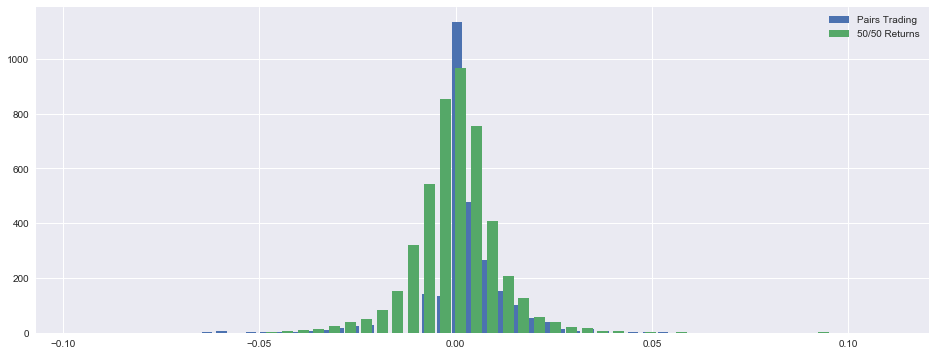

=====Strategy Returns=====
Mean return = 0.12 %
Standard deviaton = 1.16 %
Worst return = -7.65 %
Best return = 11.08 %
Lower quantile = 0.0 %
Median return = 0.02 %
Upper quantile = 0.54 %


In [5]:
fig, ax = plt.subplots(figsize=(16,6))

hist1, bins1 = np.histogram(returns, bins=50)
width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2

hist2, bins2 = np.histogram(ReturnBoth.dropna(), bins=50)
width2 = 0.7 * (bins2[1] - bins2[0])
center2 = (bins2[:-1] + bins2[1:]) / 2

ax.bar(center1, hist1, align='center', width=width1, label='Pairs Trading')
ax.bar(center2, hist2, align='center', width=width2, label='50/50 Returns')

plt.legend()
plt.show()
print('=====Strategy Returns=====')
print('Mean return =',round((returns.mean())*100,2),"%")
print('Standard deviaton =',round((returns.std())*100,2),"%")
print("==========================")
print('Worst return =',round((min(returns))*100,2),"%")
print('Best return =',round((max(returns))*100,2),"%")
print("=========================")
print('Lower quantile =',round((returns.quantile(q=0.25))*100,2),"%")
print('Median return =',round((returns.quantile(q=0.5))*100,2),"%")
print('Upper quantile =',round((returns.quantile(q=0.75))*100,2),"%")

In [6]:
maxdd = round(max(np.maximum.accumulate(cumulret)-cumulret)*100,2)

mask = returns<0
diffs = np.diff(mask.astype(int))
start_mask = np.append(True,diffs==1) 
mask1 = mask & ~(start_mask & np.append(diffs==-1,True))
id = (start_mask & mask1).cumsum()
out = np.bincount(id[mask1]-1,returns[mask1])
badd = round(max(-out)*100,2)

executionrate = round((len(returns)/len(ReturnBoth))*100,2)

spositive = returns[returns > 0]
snegative = -returns[returns < 0]
winrate = round((len(spositive)/(len(spositive)+len(snegative)))*100,2)

beta = round(returns.corr(ReturnBoth),2)

sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)

tret = round((float(cumulret[-1:]))*100,2)

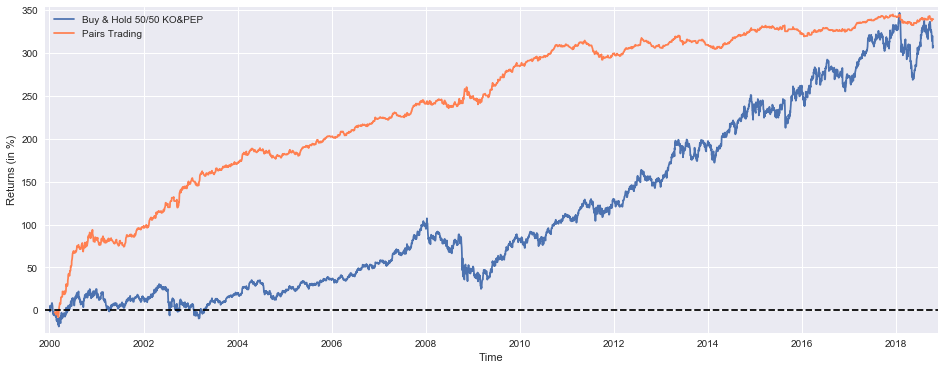

Cumulative Return =  339.47 %
Execution Rate =  61.38 %
Win Rate =  68.33 %
Maximum Loss =  22.5 %
Maximum Consecutive Loss =  14.17 %
Beta =  0.46
Sharpe =  3.97


In [7]:
plt.figure(figsize=(16,6))
plt.plot(BuyHoldBoth*100, label='Buy & Hold 50/50 KO&PEP')
plt.plot((cumulret)*100, label='Pairs Trading', color='coral')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print("Cumulative Return = ",tret,"%")
print("=========================")
print("Execution Rate = ",executionrate,"%")
print("Win Rate = ",winrate,"%")
print("=========================")
print("Maximum Loss = ",maxdd,"%")
print("Maximum Consecutive Loss = ",badd,"%")
print("=========================")
print("Beta = ",beta)
print("Sharpe = ",sharpe)